# AI4DL - AI for Deep Learning

## A sample case for Iterative addition of Phases in AI4DL

### Load Libraries

In [1]:
%matplotlib inline

import inspect
import json
import pickle

import random
import numpy as np 
import pandas as pd
import numexpr as ne
import sklearn
from sklearn import preprocessing
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
import copy

from matplotlib import pyplot as plt 

from joblib import dump, load

import os,sys,inspect

In [2]:
sys.path.append('../../package')

import AI4DL
from AI4DL import AI4DL

### 0 . Configuration

In [3]:
selected_features = ["cpu.usage", "cpu.usage.cores", "cpu.usage.pct", "cpu.usage.pct.container.requested", "mem.current", "mem.limit", "mem.usage.pct", "mem.working.set"]
container_id = "pod.id"

n_clusters = 5

## Models from DLaaS
crbm_save = "ai4dl_crbm1"
kmeans_save = "ai4dl_kmeans1.joblib"
scaler_save = "ai4dl_scaler1.joblib"
sample_dlaas = "sample-dlaas.csv"

kmeans_new_save = "ai4dl_kmeans2.joblib"
sample_vr = "sample-vr.csv"

palette = {0:'grey', 1:'green', 2:'blue', 3:'red', 4:'orange', 5:'fuchsia', 6:'tan', 7:'lightsteelblue', 8:'black'}
cpu_idx = 0 # cpu.usage
mem_idx = 4 # mem.current

### 1. Load a trained model (e.g., using DLaaS)

#### Create the AI4DL Object

In [4]:
ai4dl1 = AI4DL.AI4DL()

#### Load the model trained with DLaaS

In [5]:
ai4dl1.LoadModel(crbm_save, kmeans_save, scaler_save)
ai4dl1.exec_id = container_id
ai4dl1.features = selected_features
ai4dl1.n_features = len(selected_features)

#### Load DLaaS testing data, to check up the model

In [6]:
list_of_timeseries_dlaas = ai4dl1.TransformData(sample_dlaas)
pred_seq_phases_dlaas = ai4dl1.Predict(list_of_timeseries_dlaas)

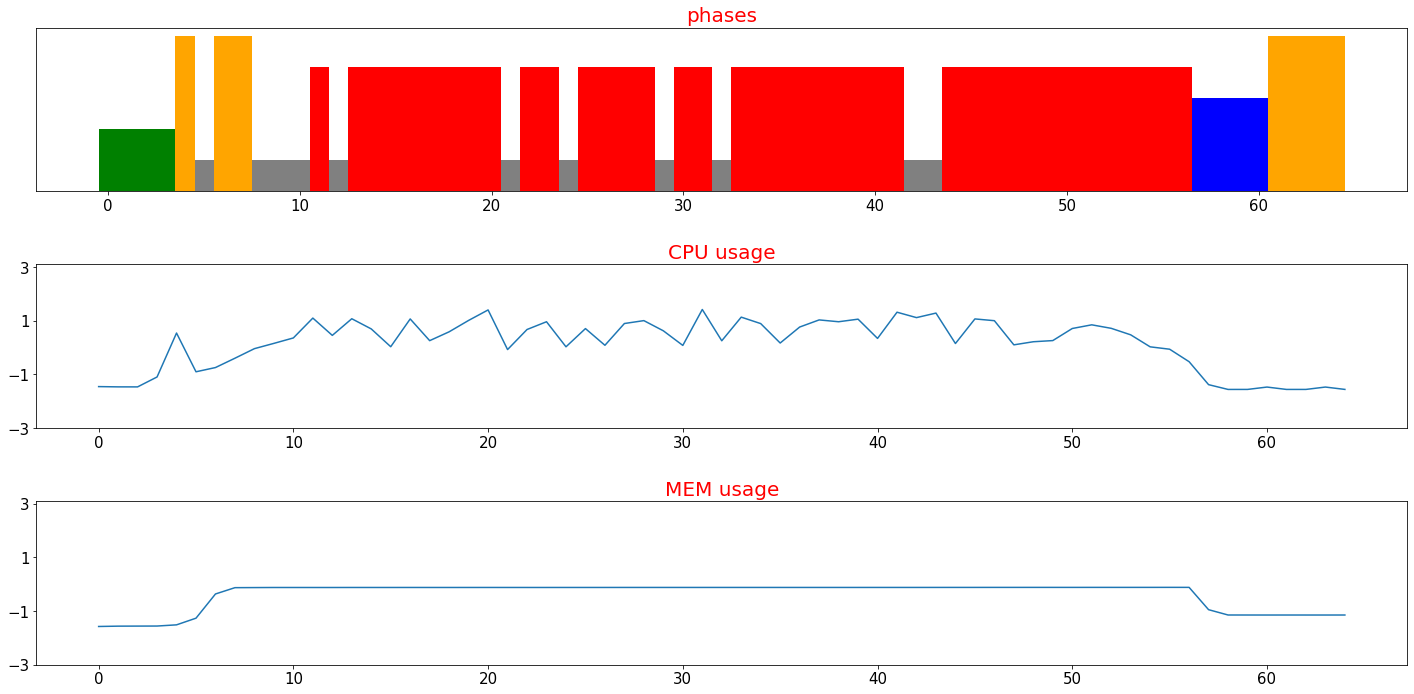

In [7]:
selected_exec = 0
ai4dl1.PrintTrace(list_of_timeseries_dlaas, pred_seq_phases_dlaas, selected_exec, cpu_idx, mem_idx, palette, col_names = ["CPU usage", "MEM usage"], f_name = "trace_dlaas.png")

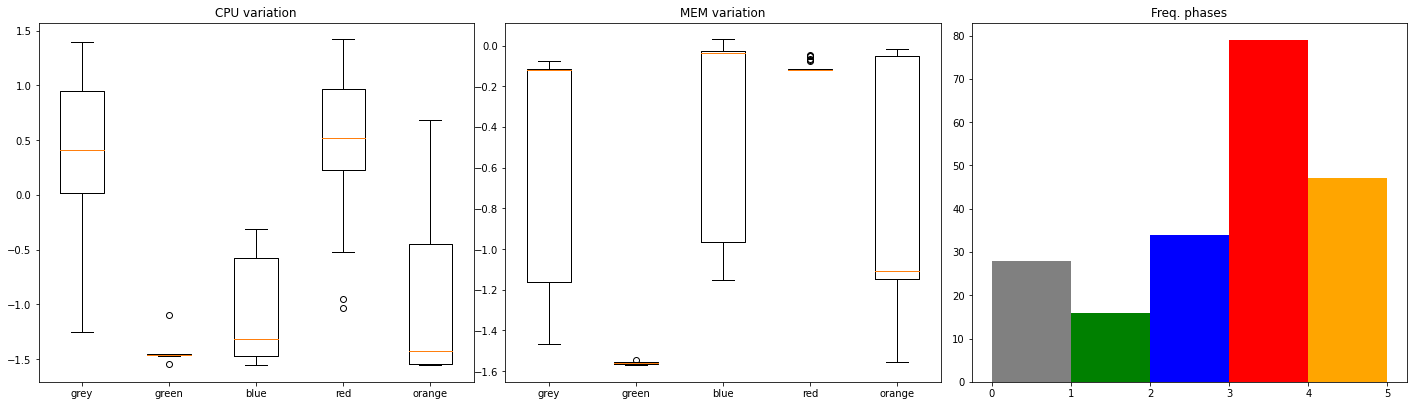

In [8]:
ai4dl1.PrintVarAnalysis(list_of_timeseries_dlaas, pred_seq_phases_dlaas, cpu_idx, mem_idx, palette, col_names = ["CPU variation", "MEM variation"], f_name = "variance_dlaas.png")

Here we observe how with DLaaS we obtain 5 phases that can represent the different behavior of a DLaas Application.

### 2. Load data from another service (e.g. Voice Recognition)

Now we load a dataset from another service (Voice Recognition), that can contain new behaviors.

**Note: here we are providing a sample dataset with few examples, just to show the format of the file and its features. You can insert here a dataset containing the "selected features" and retrain the clustering with your workloads.**

In [9]:
sample  = pd.read_csv(sample_vr)
sample.head()

,timestamp,service,pod.id,cpu.num.cores,cpu.usage,cpu.usage.cores,cpu.usage.pct,cpu.usage.pct.container.requested,mem.current,mem.limit,mem.usage.pct,mem.working.set
1,1566384070,service2,exec2,16,26388206571,1.802,11.26,43.99,20598784,19327352832,0.11,20566016
2,1566384080,service2,exec2,16,17304343700,1.154,7.21,28.17,4061585408,19327352832,21.01,4061466624
3,1566384100,service2,exec2,16,1244543750,0.090,0.56,2.20,6007820288,19327352832,31.07,6005809152
4,1566384110,service2,exec2,16,92332741,0.009,0.06,0.22,6081622016,19327352832,31.46,6079610880
5,1566384140,service2,exec2,16,5165872410,0.284,1.78,6.93,6062047232,19327352832,31.35,6060036096


In [10]:
list_of_timeseries_vr = ai4dl1.TransformData(sample_vr)
predicted_seq_phases_vr = ai4dl1.Predict(list_of_timeseries_vr)

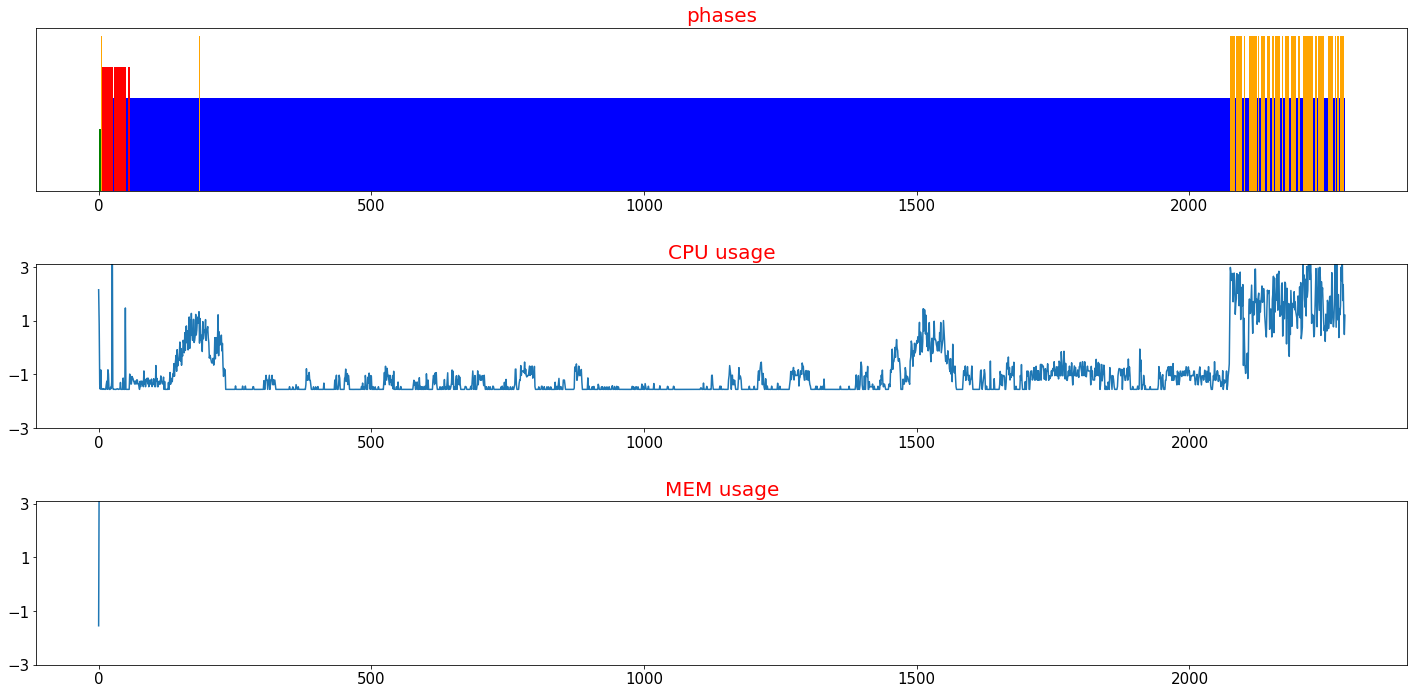

In [11]:
selected_exec = 0
ai4dl1.PrintTrace(list_of_timeseries_vr, predicted_seq_phases_vr, selected_exec, cpu_idx, mem_idx, palette, col_names = ["CPU usage", "MEM usage"], f_name = "trace_vr_pre.png")

We observe that a phase (blue #2) could be split in new behaviors not found in DLaaS, creating new clusters

#### Analysis of variance in DLaaS and VR (without update)

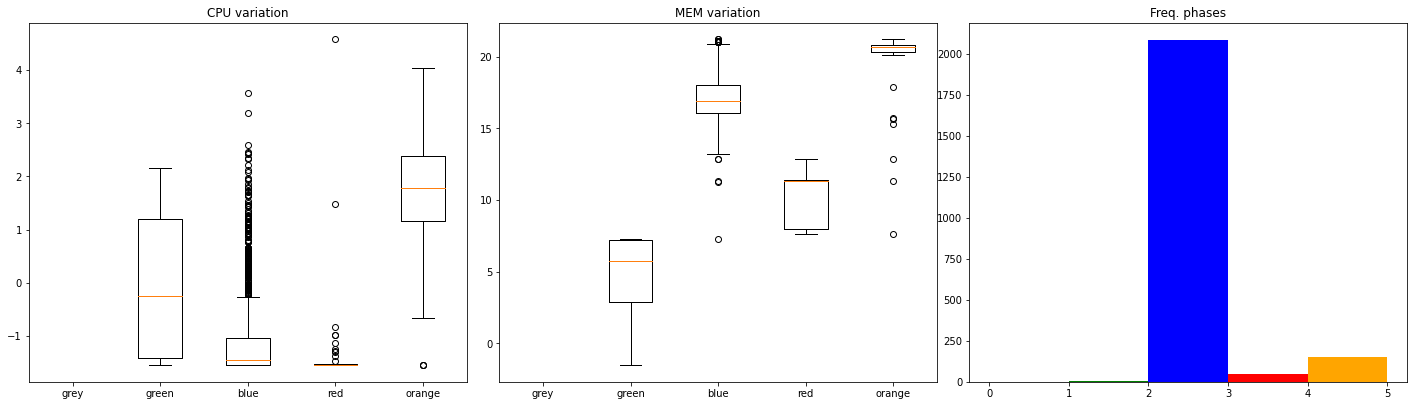

In [12]:
ai4dl1.PrintVarAnalysis(list_of_timeseries_vr, predicted_seq_phases_vr, cpu_idx, mem_idx, palette, col_names = ["CPU variation", "MEM variation"], f_name = "variance_vr_pre.png")

#### Update of the Model with new phases

We're doing here the process manually, to show step-by-step the process.

First we select the cluster we're going to split (i.e. the blue cluster #2)

In [13]:
target_cluster = 2

Get activations from the CRBM with the new data

In [14]:
list_of_activations = []
for x in list_of_timeseries_vr:
    step_output = ai4dl1.pipeline.getStep(0).predict(x)
    list_of_activations.append(step_output)
X_activations = np.vstack(list_of_activations)

We find those points that belong to the Phase that we want to split

In [15]:
selected_activations = []
count = 0
for x in range(0, len(predicted_seq_phases_vr)):
    for y in range(0, len(predicted_seq_phases_vr[x])):
        if predicted_seq_phases_vr[x][y] == target_cluster:
            selected_activations.append(copy.deepcopy(X_activations[count]))
        count = count + 1
X4_activations = np.vstack(selected_activations)

Now we train a K-Means only for that specific cluster. We decide to create 4 new clusters from this one, and use the activations.

**Note: as we're providing a sample dataset, we're providing also the already trained sub-clustering model.**

In [16]:
#kmeans_X4 = sklearn.cluster.KMeans(n_clusters=4, random_state=123)
#kmeans_X4.fit(X4_activations)
#dump(kmeans_X4, kmeans_new_save)

kmeans_X4 = load(kmeans_new_save)

Now we pass the points through the clustering and update the detected phases using the new clusters

In [17]:
pred_seq_phases_X4 = copy.deepcopy(predicted_seq_phases_vr)

count = 0
for x in range(0, len(predicted_seq_phases_vr)):
    for y in range(0, len(predicted_seq_phases_vr[x])):
        if predicted_seq_phases_vr[x][y] == target_cluster:
            pred_seq_phases_X4[x][y] = n_clusters + kmeans_X4.predict([X4_activations[count]])[0]
            count = count + 1

Finally, we observe how the selected phase is split in more detailed behaviors

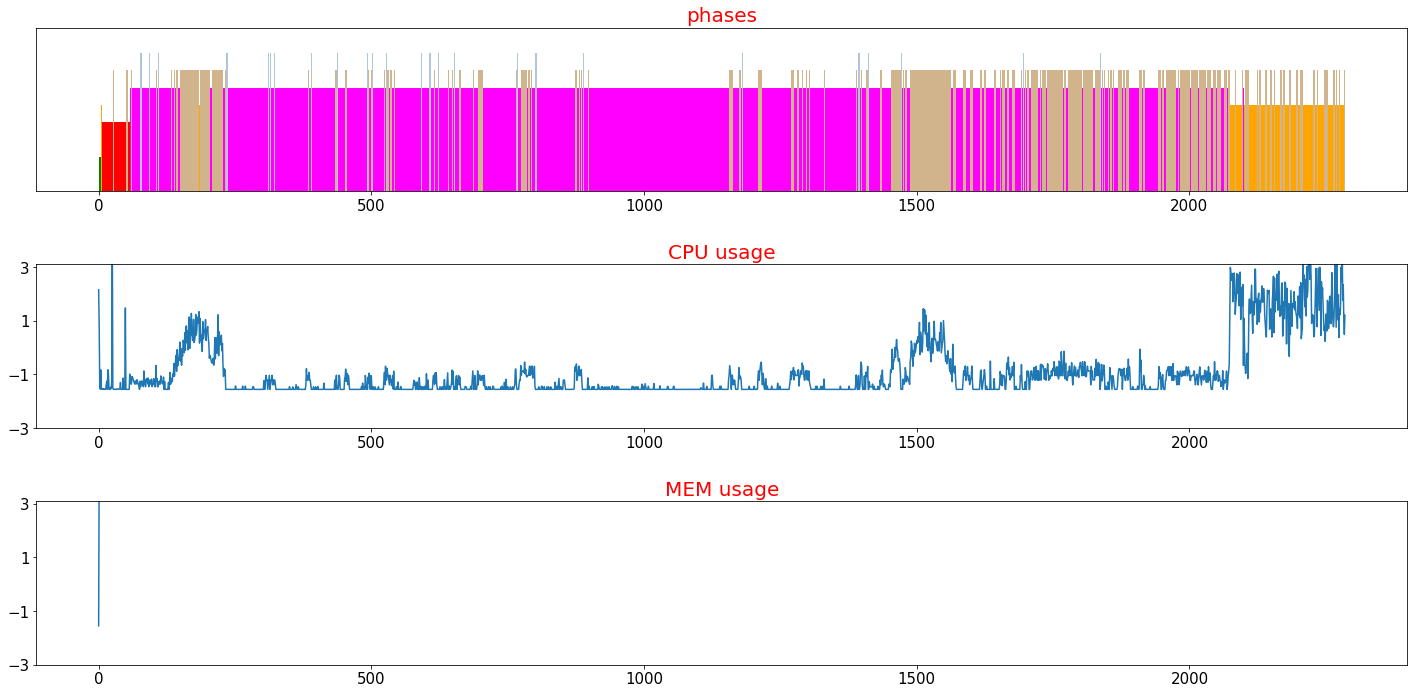

In [18]:
selected_exec = 0
ai4dl1.PrintTrace(list_of_timeseries_vr,
                  pred_seq_phases_X4,
                  selected_exec, cpu_idx, mem_idx, palette, col_names = ["CPU usage", "MEM usage"], f_name = "trace_vr_post.png")

#### Analysis of variance in DLaaS and VR (after update)

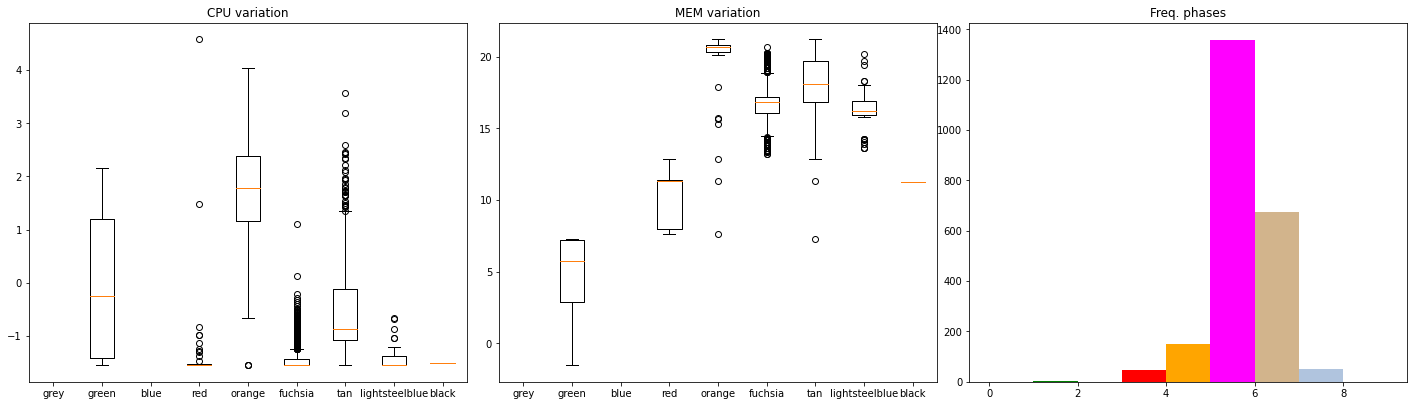

In [19]:
ai4dl1.PrintVarAnalysis(list_of_timeseries_vr, pred_seq_phases_X4, cpu_idx, mem_idx, palette, col_names = ["CPU variation", "MEM variation"], f_name = "variance_vr_post.png")